In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import auc

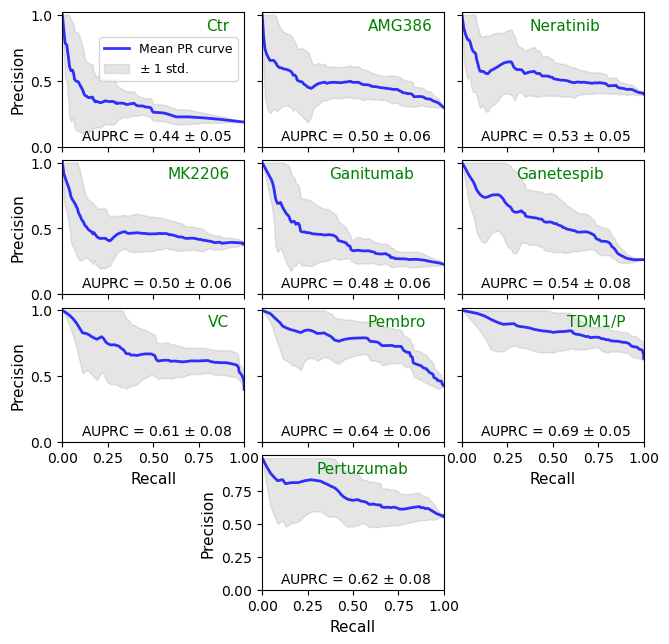

In [6]:
arm_short_name = ['Ctr', 'AMG386', 'N', 'MK2206', 'Ganitumab',  'Ganetespib', 'VC', 'Pembro', 'TDM1/P', 'Pertuzumab']
#arm_short_name = ['TDM1/P', 'Pertuzumab']

fig, ax = plt.subplots(4,3, figsize = (7.5,7.5) )
auprc_all =[]
directory_out = 'res_xgb35_analysis/'
for ai, a in enumerate(arm_short_name):
    if a == 'TDM1/P':
        b = 'TDM1P'
    else:
        b = a
    filename = 'res_xgb35/results_xgb35_hh1norm1_' + b + '_precr.csv'
    precr = pd.read_csv(filename, header = None)
    precr.columns = ['prec', 'recall', 'thresholds']
    
    precs = []
    recs  = []
    auprcs = []
    mean_probTh = np.linspace(0, 1, 101)
    run = precr.index[precr['prec'] == 100].tolist()
    for i in range(len(run)+1):
        if i == 0:
            prec=precr.iloc[:run[0],0].values
            rec =precr.iloc[:run[0],1].values
            probTh = precr.iloc[:run[0],2].values
        elif i == len(run):
            prec=precr.iloc[run[i-1]+1:precr.shape[0]+1,0].values
            rec=precr.iloc[run[i-1]+1:precr.shape[0]+1,1].values
            probTh=precr.iloc[run[i-1]+1:precr.shape[0]+1,2].values
        else:
            prec=precr.iloc[run[i-1]+1:run[i],0].values
            rec=precr.iloc[run[i-1]+1:run[i],1].values
            probTh=precr.iloc[run[i-1]+1:run[i],2].values
        
        interp_prec = np.interp(mean_probTh,probTh, prec)
        precs.append(interp_prec)

        interp_rec = np.interp(mean_probTh,probTh, rec)
        recs.append(interp_rec)

        #compute AUPRC, interp_rec is in descreasing order
        temp=(interp_rec[:-1]-interp_rec[1:])* (interp_prec[1:]+interp_rec[:-1])/2
        auprcs.append(temp.sum())
    
    mean_prec = np.mean(precs, axis=0)
    std_prec = np.std(precs, axis=0)
    mean_recall = np.mean(recs, axis=0)
    std_recall = np.std(recs, axis = 0)
    mean_auprc = np.mean(auprcs)
    std_auprc = np.std(auprcs)
   
    temp = np.array([mean_prec, mean_recall, mean_probTh, std_prec, std_recall]) 
    df_precall = pd.DataFrame(temp.T, columns =['precision', 'recall', 'prob_threshold', 'prec-std', 'recall_std'])

    r, c = ai//3, ai%3
    if r == 3:
        c +=1
    ax[r,c].plot(
         mean_recall,
         mean_prec,
         color="b",
         label="Mean PR curve",
         lw=2,
         alpha=0.8,
    )
    
    precs_upper = np.minimum(mean_prec + std_prec, 1)
    precs_lower = np.maximum(mean_prec - std_prec, 0)
    ax[r,c].fill_between(
         mean_recall,
         precs_lower,
         precs_upper,
         color="grey",
         alpha=0.2,
         label=r"$\pm$ 1 std.",
    )

    #ax.plot(mean_recall, precs_upper,color="r")
    #ax.plot(mean_recall, precs_lower,color="g")
    
    ax[r,c].set(
         xlim=[0, 1],
         ylim=[0, 1.02]
         #title="Receiver operating characteristic example",
    )
    
    ft = 11
    plt.xticks(fontsize=ft)
    if r < 3:
        plt.yticks(fontsize=ft)
    else:
        ax[r,c].set_yticks([0, 0.25, 0.50, 0.75])

    if r < 3 and c == 0:
        ax[r,c].set_ylabel("Precision", fontsize = ft)
    if r == 3 and c == 1:
        ax[r,c].set_ylabel("Precision", fontsize = ft)
    
    if r == 2 and c != 1:
        ax[r,c].set_xlabel("Recall", fontsize = ft)
    if r == 3 and c == 1:
        ax[r,c].set_xlabel("Recall", fontsize = ft)
    
    if r != 3 and c != 0: 
        ax[r,c].set_yticklabels([])
    
    if r < 2: 
        ax[r,c].set_xticklabels([])
    if r == 2 and c == 1: 
        ax[r,c].set_xticklabels([])
        
    if a == 'N':
        a = 'Neratinib'
    x=1-len(a)*0.07
    if a =='VC':
        x=0.8
    ax[r,c].text(x, 0.88, a, 
         fontsize = ft, color = 'g')

    ax[r,c].text(0.1, 0.05,r"AUPRC = %0.2f $\pm$ %0.2f" % (mean_auprc, std_auprc))
    if r == 0 and c ==0: 
        ax[r,c].legend(loc='upper right', bbox_to_anchor=(1, 0.86), fontsize = 9) 

    df_precall = np.round(df_precall,4)
    filename = directory_out + 'precall_' + b + '.csv'
    df_precall.to_csv(filename)

    auprc_all.append([mean_auprc, std_auprc])


fig.delaxes(ax[3, 0])
fig.delaxes(ax[3, 2])
fig.subplots_adjust(wspace=0.1, hspace=0.1)
filename = directory_out + 'fig_prc.png'
plt.savefig(filename)

In [7]:
# save AUPRC
auprc_all = pd.DataFrame(auprc_all,columns =['auprc_mean', 'auprc_std'])
auprc_all.index = arm_short_name
auprc_all = np.round(auprc_all,4)
auprc_all.to_csv( directory_out + 'all_auprc.csv')

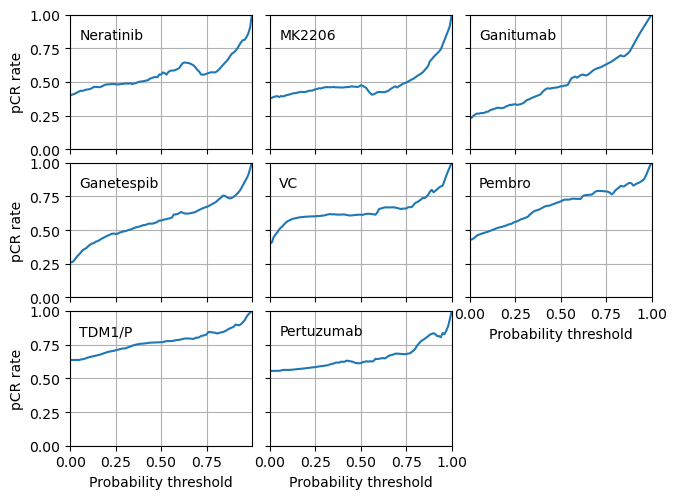

In [8]:
#plot mean precision versus cutoff probability
fig, ax = plt.subplots(3,3, figsize =(7.5,5.6))
arm_short_name = ['N', 'MK2206', 'Ganitumab',  'Ganetespib', 'VC', 'Pembro', 'TDM1/P', 'Pertuzumab']
for i, a in enumerate(arm_short_name):
    if a == 'TDM1/P':
        b = 'TDM1P'
    else:
        b = a
    filename = directory_out + 'precall_' + b + '.csv'
    precall = pd.read_csv(filename)

    r,c=i//3,i%3
    ax[r,c].plot(precall['prob_threshold'],precall['precision'])
    if r == 2:
        ax[r,c].set_xlabel('Probability threshold')
    if r == 1 and c == 2:
         ax[r,c].set_xlabel('Probability threshold')
    if c == 0:
        ax[r,c].set_ylabel('pCR rate')
    ax[r,c].set_xlim(0,1)
    ax[r,c].set_ylim(0,1)
    ax[r,c].grid()
    if a == 'N':
        a = 'Neratinib'
    ax[r,c].text(0.05, 0.9, a, ha = 'left', va = 'top',transform=ax[r,c].transAxes)

    if c > 0: 
        ax[r,c].set_yticklabels([])
    if r == 0: 
        ax[r,c].set_xticklabels([])
    elif r == 1 and c < 2:
        ax[r,c].set_xticklabels([])

    if b == 'TDM1P':
        ax[r,c].set_xticks([0, 0.25, 0.50, 0.75])


fig.delaxes(ax[2, 2])
fig.subplots_adjust(wspace=0.1, hspace=0.1)

# save pCR vs probability threshold
filename = directory_out + 'fig_pCR_prob.png'
plt.savefig(filename)